![](https://i.ibb.co/G0sLBVs/30-Days-ML-Hero.png). 


Machine learning beginner → Kaggle competitor in 30 days. Non-coders welcome.



The dataset is used for this competition is synthetic, but based on a real dataset. The original dataset deals with predicting the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

# Loading data

In [ ]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
! kaggle competitions download -c 30-days-of-ml -p /content/drive/My\Drive/kaggle/30_ML

 36% 9.00M/25.2M [00:00<00:00, 74.0MB/s]
100% 25.2M/25.2M [00:00<00:00, 99.0MB/s]
 87% 35.0M/40.3M [00:00<00:00, 61.8MB/s]
100% 40.3M/40.3M [00:00<00:00, 89.6MB/s]
  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 155MB/s]


In [ ]:
%%capture
!pip install catboost

In [ ]:
%%capture
!pip install category_encoders

In [ ]:
%%capture
!pip install -U keras-tuner

In [ ]:
%%capture
!pip install hyperopt

In [ ]:
import pandas as pd
import numpy as np

import hyperopt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from tensorflow.keras.optimizers import Adam, Nadam

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
import warnings
from kerastuner.tuners import RandomSearch, BayesianOptimization
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import 

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from category_encoders import MEstimateEncoder

from sklearn.ensemble import VotingRegressor
from scipy.stats import reciprocal, uniform

from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor


warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

train = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/train.csv.zip')
test = pd.read_csv('/content/drive/MyDrive/kaggle/30_ML/test.csv.zip')

In [ ]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [ ]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,B,B,B,C,B,B,A,E,E,I,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,5,A,B,A,C,B,C,A,E,C,H,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,15,B,A,A,A,B,B,A,E,D,K,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,16,B,B,A,C,B,D,A,E,A,N,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,17,B,B,A,C,B,C,A,E,C,F,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [ ]:
X_test = test.drop(['id'], axis=1)

# Ensemble

In [ ]:
features, target = split_data(train, 'target')

In [ ]:
cat_feature = list(features.select_dtypes(include=['object', 'category']))
cat_feature 

['cat0',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'cat5',
 'cat6',
 'cat7',
 'cat8',
 'cat9']

In [ ]:
encoder = LabelEncoder()
# encoder = OrdinalEncoder()

In [ ]:
for cat in cat_feature:
    encoder = LabelEncoder()
    encoder.fit(list(features[cat].values)) 
    features[cat] = encoder.transform(list(features[cat].values))


In [ ]:
features.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,1,2,1,1,0,4,2,13,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
1,2,1,1,0,0,1,3,0,5,0,14,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
2,3,0,0,0,2,1,3,0,3,0,5,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
3,4,1,1,0,2,1,3,0,4,2,10,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
4,6,0,0,0,2,1,3,0,4,0,13,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


In [ ]:
features = features.drop('id', axis=1)

In [ ]:
test_id = test ['id']

In [ ]:
# X_test_cv_1 = X_test.copy()
# X_test_cv = encoder_1.transform(X_test_cv_1)
# X_test_cv[cat_feature] = encoder.transform(X_test_cv[cat_feature])

for cat in cat_feature:
    X_test[cat] = encoder.transform(list(X_test[cat].values))


In [ ]:
X_test.shape

(200000, 24)

#Keras


In [ ]:
features.shape, X_test.shape

((300000, 24), (200000, 24))

In [ ]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [ ]:
y_val_XGB.mean()

8.242420668044563

In [ ]:
y_sanity = np.ones(y_val_XGB.shape[0])*y_val_XGB.mean()

In [ ]:
y_sanity

array([8.24242067, 8.24242067, 8.24242067, ..., 8.24242067, 8.24242067,
       8.24242067])

In [ ]:
X_train_XGB.shape

(225000, 24)

In [ ]:
def build_model(hp):

    model = Sequential()
  
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=200,    
                                   max_value=300,   
                                   step=25),  
                    input_dim=24, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_input_1',    
                                   min_value=150,    
                                   max_value=250,   
                                   step=25), 
                    activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_input_2',    
                                   min_value=50,    
                                   max_value=100,   
                                   step=25), 
                    activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Nadam(
        hp.Choice("learning_rate", values=[0.001, 0.0001])
        ),
        loss='mae',
        metrics=['mse'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mse',    
                                 
    max_trials=5,                
    directory='test_directory_24',
    overwrite=True   
    )


early_stopping = EarlyStopping(

    mode='min', 
    patience=20,
    restore_best_weights=True,
)

NameError: ignored

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 300, 'step': 25, 'sampling': None}
units_input_1 (Int)
{'default': None, 'conditions': [], 'min_value': 150, 'max_value': 250, 'step': 25, 'sampling': None}
units_input_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 100, 'step': 25, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=50, validation_data=(X_val_XGB, y_val_XGB)
             )

In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5000      
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 75)                15075     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7

In [ ]:
UNITS = 200
UNITS_HIDDEN_1 = 200
UNITS_HIDDEN_2 = 75

OPTIMIZER = Nadam(lr=0.0001)
BATCH_SIZE_PER_REPLICA = 256

ACTIVATION='elu'

In [ ]:

model = Sequential()

model.add(Dense(units=200, 
                input_dim=24, activation=elu))
model.add(BatchNormalization())
model.add(Dense(units=200, activation=elu))
model.add(BatchNormalization())
model.add(Dense(units=UNITS75_HIDDEN_2, activation=elu))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(
    optimizer=OPTIMIZER,
    loss='mae',
    metrics=['mse'])


early_stopping = EarlyStopping(
    min_delta=0.0005,
    mode='min', 
    patience=20,
    restore_best_weights=True,
)

Epoch 1/100
879/879 [==============================] - 9s 9ms/step - loss: 7.3307 - mse: 57.6553 - val_loss: 6.0962 - val_mse: 40.4301
Epoch 2/100
879/879 [==============================] - 7s 8ms/step - loss: 3.8555 - mse: 18.4188 - val_loss: 1.2551 - val_mse: 2.1768
Epoch 3/100
879/879 [==============================] - 7s 8ms/step - loss: 0.6900 - mse: 0.7867 - val_loss: 0.5910 - val_mse: 0.5585
Epoch 4/100
879/879 [==============================] - 7s 8ms/step - loss: 0.5929 - mse: 0.5625 - val_loss: 0.5867 - val_mse: 0.5527
Epoch 5/100
879/879 [==============================] - 7s 8ms/step - loss: 0.5905 - mse: 0.5582 - val_loss: 0.5864 - val_mse: 0.5497
Epoch 6/100
879/879 [==============================] - 7s 8ms/step - loss: 0.5892 - mse: 0.5565 - val_loss: 0.5901 - val_mse: 0.5590
Epoch 7/100
879/879 [==============================] - 7s 8ms/step - loss: 0.5887 - mse: 0.5557 - val_loss: 0.5891 - val_mse: 0.5560
Epoch 8/100
879/879 [==============================] - 7s 8ms/step

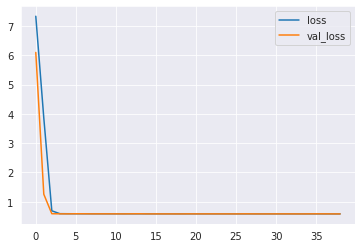

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=100,
    callbacks=early_stopping,
    verbose=1,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7405098758285182


In [ ]:
UNITS = 2048
UNITS_HIDDEN_1 = 2048
UNITS_HIDDEN_2 = 2048
UNITS_HIDDEN_3 = 2048


optimizer=Nadam(learning_rate=0.001) 

ACTIVATION='relu'
BATCH_SIZE_PER_REPLICA = 50

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.0005,
    mode='min', 
    patience=20,
    restore_best_weights=True,
)


model = Sequential()
model.add(Dense(72, input_dim = 24, kernel_initializer='normal')
model.add(Dropout(0.2))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(72, kernel_initializer='normal')
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(Dense(1))



In [ ]:
model.compile(
    optimizer=optimizer, 
    loss='mae'
)

Epoch 1/70
4500/4500 - 5s - loss: 0.6123 - val_loss: 0.5932
Epoch 2/70
4500/4500 - 5s - loss: 0.5883 - val_loss: 0.5833
Epoch 3/70
4500/4500 - 5s - loss: 0.5874 - val_loss: 0.5903
Epoch 4/70
4500/4500 - 5s - loss: 0.5874 - val_loss: 0.5838
Epoch 5/70
4500/4500 - 5s - loss: 0.5870 - val_loss: 0.5861
Epoch 6/70
4500/4500 - 5s - loss: 0.5869 - val_loss: 0.5840
Epoch 7/70
4500/4500 - 5s - loss: 0.5867 - val_loss: 0.5837
Epoch 8/70
4500/4500 - 5s - loss: 0.5868 - val_loss: 0.5835
Epoch 9/70
4500/4500 - 5s - loss: 0.5868 - val_loss: 0.5831
Epoch 10/70
4500/4500 - 5s - loss: 0.5866 - val_loss: 0.5856
Epoch 11/70
4500/4500 - 5s - loss: 0.5866 - val_loss: 0.5862
Epoch 12/70
4500/4500 - 5s - loss: 0.5865 - val_loss: 0.5830
Epoch 13/70
4500/4500 - 5s - loss: 0.5864 - val_loss: 0.5832
Epoch 14/70
4500/4500 - 5s - loss: 0.5864 - val_loss: 0.5844
Epoch 15/70
4500/4500 - 5s - loss: 0.5864 - val_loss: 0.5824
Epoch 16/70
4500/4500 - 5s - loss: 0.5863 - val_loss: 0.5826
Epoch 17/70
4500/4500 - 5s - loss

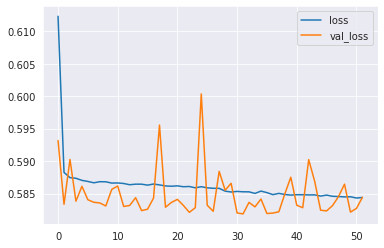

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=70,
    callbacks=early_stopping,
    verbose=2,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7360686302975115


In [ ]:
X_test.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras.csv',index=False)
from google.colab import files
files.download("my_submission_keras.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.016157
1,5,8.234062
2,15,8.317445
3,16,8.186908
4,17,8.254500


#Keras 2

In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])    
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=64,    
                                   max_value=1024,   
                                   step=32),
                    input_dim=24,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=256,   
                                   step=32),
                    activation=activation_choice))  
    model.add(Dropout(0.3))   
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=256,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=42,                
    directory='test_directory_2'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=20,                 
             validation_split=0.2,     
             )

Trial 42 Complete [00h 00m 41s]
mae: 0.5903564095497131

Best mae So Far: 0.586026668548584
Total elapsed time: 00h 38m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=3)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 960)               24000     
_________________________________________________________________
dense_1 (Dense)              (None, 192)               184512    
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 192)               37056     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 193       
Total params: 245,761
Trainable params: 245,761
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 4s 2ms/step - loss: 0.6233 - mae: 0.6233

Model: "sequential"
_________

In [ ]:
UNITS = 128
UNITS_HIDDEN_1 = 192

UNITS_HIDDEN_2 = 192
ACTIVATION = 'relu'

BATCH_SIZE_PER_REPLICA = 256

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dropout(rate=0.3),
    layers.Dense(UNITS_HIDDEN_2, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5825


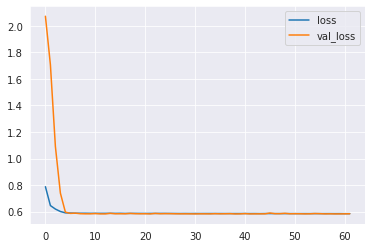

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7381312326719619


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_3lay.csv',index=False)
from google.colab import files
files.download("my_submission_keras_3lay.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.032942
1,5,8.287011
2,15,8.326889
3,16,8.106340
4,17,8.170339


#Keras 3 (reBoot)

In [ ]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'tanh'])    
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=32,    
                                   max_value=512,   
                                   step=32),
                    input_dim=24,
                    activation=activation_choice))
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=32,   
                                   max_value=512,   
                                   step=32),
                    activation=activation_choice))   
    model.add(Dense(1))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=42,                
    directory='test_directory_8'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=256,           
             epochs=30,                 
             validation_split=0.2,     
             )

Trial 43 Complete [00h 02m 22s]
mae: 0.586673378944397

Best mae So Far: 0.5848336815834045
Total elapsed time: 01h 22m 20s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 6s 2ms/step - loss: 0.5825 - mae: 0.5825

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 320)               8000      
_________________________________________________________________
dense_1 (Dens

In [ ]:
UNITS = 128
UNITS_HIDDEN_1 = 192
UNITS_HIDDEN_2 = 192
optimizer = Adam(lr=0.0005) 
ACTIVATION='relu'

BATCH_SIZE_PER_REPLICA = 16

In [ ]:
early_stopping = EarlyStopping(
    mode='min', 
    patience=50,
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dropout(rate=0.3),
    layers.Dense(UNITS_HIDDEN_2, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer=optimizer, 
    loss='mae'
)

Minimum Validation Loss: 0.5828


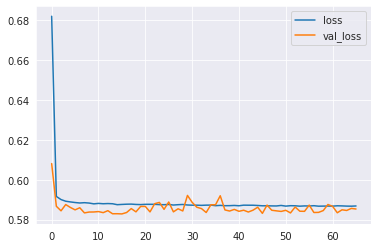

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=10000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7378086856116519


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_adam2layv2.csv',index=False)
from google.colab import files
files.download("my_submission_keras_adam2layv2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.129260
1,5,8.274261
2,15,8.342939
3,16,8.193087
4,17,8.249970


#Keras 4

In [ ]:
def build_model(hp):
    model = Sequential()
       
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=64,    
                                   max_value=512,   
                                   step=32),
                    input_dim=24, 
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=64,   
                                   max_value=512,   
                                   step=32),
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(1)) 
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=10,                
    directory='test_directory_7'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=512,           
             epochs=20,                 
             validation_split=0.2,     
             )

Trial 10 Complete [00h 00m 48s]
mae: 0.5911945104598999

Best mae So Far: 0.5876796841621399
Total elapsed time: 00h 10m 21s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               4800      
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 192)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 352)               67936     
_________________________________________________________________
dropout_1 (Dropout)          (None, 352)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 352)               1408      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [ ]:
UNITS = 288
UNITS_HIDDEN_1 = 352
ACTIVATION = 'relu'
BATCH_SIZE_PER_REPLICA = 512

In [ ]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=50, 
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5830


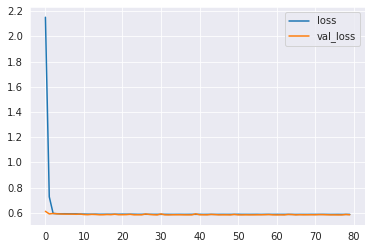

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7388541738165599


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_4.csv',index=False)
from google.colab import files
files.download("my_submission_keras_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.043885
1,5,8.237064
2,15,8.298949
3,16,8.102369
4,17,8.143108


# Keras 5

In [ ]:
def build_model(hp):
    model = Sequential()
       
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=24,    
                                   max_value=216,   
                                   step=12),
                    input_dim=24, 
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_hidden',        
                                   min_value=24,   
                                   max_value=128,   
                                   step=24),
                    activation='relu'))
    model.add(Dense(1)) 
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','SGD']),
        loss='mae',
        metrics=['mae'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mae',    
                                 
    max_trials=10,                
    directory='test_directory_8'     
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 24, 'max_value': 216, 'step': 12, 'sampling': None}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 24, 'max_value': 128, 'step': 24, 'sampling': None}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(X_train_XGB,                  
             y_train_XGB,                  
             batch_size=16,           
             epochs=10,                 
             validation_split=0.2,     
             )

Trial 10 Complete [00h 04m 22s]
mae: 0.593205451965332

Best mae So Far: 0.5923649072647095
Total elapsed time: 00h 51m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_XGB, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 84)                2100      
_________________________________________________________________
dropout (Dropout)            (None, 84)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 120)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 12,757
Trainable params: 12,589
Non-trainable params: 168
_________________________________________________________________
2344/2344 [==============================] - 3s 1ms/step - loss: 0.5896 - mae: 0.5896

Model: "sequential"
_________

In [ ]:
UNITS = 48
UNITS_HIDDEN_1 = 72
ACTIVATION = 'relu'
BATCH_SIZE_PER_REPLICA = 16

In [ ]:
early_stopping = EarlyStopping(
    mode='min', 
    patience=200,
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(UNITS, ACTIVATION, input_shape=[X_train_XGB.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(UNITS_HIDDEN_1, ACTIVATION),
    layers.Dense(1)

])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='mae'
)

Minimum Validation Loss: 0.5841


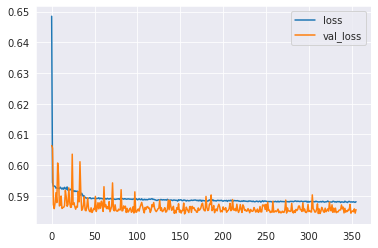

In [ ]:
history = model.fit(
    X_train_XGB, y_train_XGB,
    validation_data=(X_val_XGB, y_val_XGB),
    batch_size=BATCH_SIZE_PER_REPLICA,
    epochs=1000,
    callbacks=early_stopping,
    verbose=0,
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [ ]:
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))

0.7397565453850714


In [ ]:
X_test_cv.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1,1,1,2,1,1,0,4,4,8,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0,1,0,2,1,2,0,4,2,7,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1,0,0,0,1,1,0,4,3,10,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1,1,0,2,1,3,0,4,0,13,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1,1,0,2,1,2,0,4,2,5,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412


In [ ]:
preds = model.predict(X_test_cv)

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test['id']
sub['target'] = preds
sub.to_csv('my_submission_keras_5.csv',index=False)
from google.colab import files
files.download("my_submission_keras_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub.head()

,Id,target
0,0,8.097563
1,5,8.221552
2,15,8.291040
3,16,8.098898
4,17,8.120381


#LGMB/XGB


In [ ]:
#LGMB

params_lgb =  {'n_estimators' : 20000, 
                             'max_depth' : 2, 
                             'learning_rate' : 0.1, 
                             'subsample' : 0.95, 'colsample_bytree' : 0.85, 
                             'reg_alpha' : 30.0, 
                             'reg_lambda' : 25.0 , 
                             'num_leaves' : 4, 
                             'max_bin' : 512,
                              'random_state':42,
    

}


#XGBboost

xgb_params = {
    'n_estimators': 20000,
    'learning_rate': 0.036283,
    'subsample': 0.95,
    'colsample_bytree': 0.11,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 66.1,
    'reg_alpha': 15.9,
    'random_state':42,
    'verbosity': 0,
    'n_jobs': 4
}


xgb_params_2 = {
    'n_estimators': 20000, 
      'max_depth': 3, 
      'learning_rate': 0.03628302216953097, 
      'gamma': 0, 
      'min_child_weight': 1, 
      'subsample': 0.7875490025178415, 
      'colsample_bytree': 0.11807135201147481, 
      'reg_alpha': 23.13181079976304, 
      'reg_lambda': 0.0008746338866473539,
      'random_state':42,
      'verbosity': 0,
      'n_jobs': 4
}


xgb_params_3 = {'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 20000,
    'learning_rate': 0.036283,
    'reg_lambda': 0.0008746,
    'reg_alpha': 23.13181,
    'subsample': 0.787549,
    'colsample_bytree': 0.11807,
    'max_depth':3,

    }

cat_params = {'depth': 2, 
              'learning_rate': 0.09926804171774896, 
              'boosting_type': 'Plain', 
              'bootstrap_type': 'Bernoulli', 
              'l2_leaf_reg': 4.772285782383867, 
              'iterations': 20000, 
              'subsample': 0.8695598930707127,
              'random_state': 42}


### Stacking

In [ ]:
XGB_1 = XGBRegressor(**xgb_params)
XGB_2 = XGBRegressor(**xgb_params_2)
XGB_3 = XGBRegressor(**xgb_params_3)
LGBM = LGBMRegressor(**params_lgb)
CAT = CatBoostRegressor(**cat_params)

In [ ]:
estimators = [XGB_1, XGB_2, LGBM, XGB_3, CAT]

In [ ]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [ ]:
X, X_val, y,y_val = train_test_split(X_train_XGB, y_train_XGB, test_size=0.25,
                                                                  random_state=42)
for estimator in estimators:
    print('Обучение', estimator)

    estimator.fit(X, y, eval_set=[(X_val, y_val)], verbose=400,
                  early_stopping_rounds=2000)

Обучение XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.11, gamma=0,
             importance_type='gain', learning_rate=0.036283, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20000,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=15.9, reg_lambda=66.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=0)
[0]	validation_0-rmse:7.49965
Will train until validation_0-rmse hasn't improved in 2000 rounds.
[400]	validation_0-rmse:0.736946
[800]	validation_0-rmse:0.732241
[1200]	validation_0-rmse:0.72943
[1600]	validation_0-rmse:0.727771
[2000]	validation_0-rmse:0.726539
[2400]	validation_0-rmse:0.725532
[2800]	validation_0-rmse:0.724644
[3200]	validation_0-rmse:0.723956
[3600]	validation_0-rmse:0.723347
[4000]	validation_0-rmse:0.722898
[4400]	validation_0-rmse:0.722492
[4800]	validation_0-r

In [ ]:
mse = np.zeros(5)
for index, estimator in enumerate(estimators):
   mse[index] = mean_squared_error(y_val, estimator.predict(X_val), squared=False)

In [ ]:
mse

array([0.71917944, 0.71888615, 0.7200241 , 0.71880307, 0.72170131])

In [ ]:
X_val_predictions = np.empty((X_val_XGB.shape[0], len(estimators)), dtype=np.float64)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val_XGB)

In [ ]:
X_val_predictions

array([[8.24831676, 8.23445129, 8.28648282, 8.25332737, 8.25822505],
       [8.45505714, 8.43789196, 8.43109263, 8.43840981, 8.38646514],
       [8.32421875, 8.33506775, 8.33097076, 8.31651688, 8.33980802],
       ...,
       [8.50166702, 8.48759842, 8.42260913, 8.50744629, 8.41014027],
       [8.00345993, 8.05562115, 8.06452948, 8.0523653 , 8.08887131],
       [8.46993256, 8.46299934, 8.46212868, 8.46055984, 8.40022989]])

In [ ]:
def build_model(hp):

    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'selu', 'elu'])
    model.add(Dense(units=hp.Int('units_input',    
                                   min_value=4,    
                                   max_value=8,   
                                   step=2),  
                    input_dim=X_val_predictions.shape[1], activation=activation_choice))
    model.add(Dense(units=1, activation=activation_choice))
    
    model.compile(
        optimizer=keras.optimizers.Nadam(lr=0.0001),
        loss='mae',
        metrics=['mse'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,                 
    objective='mse',    
                        
    max_trials=5,                
    directory='test_directory_24',
    overwrite=True   
    )


early_stopping = EarlyStopping(

    mode='min', 
    patience=20,
    restore_best_weights=True,
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu'], 'ordered': False}
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 8, 'step': 2, 'sampling': None}


In [ ]:
tuner.search(X_val_predictions,                  
             y_val_XGB,                  
             batch_size=8,           
             epochs=10, validation_split=0.25
             )

Trial 5 Complete [00h 02m 22s]
mse: 0.5166059136390686

Best mse So Far: 0.5164284110069275
Total elapsed time: 00h 11m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
for model in models:
  model.summary()
  model.evaluate(X_val_predictions, y_val_XGB)
  print() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
2344/2344 [==============================] - 3s 1ms/step - loss: 0.5705 - mse: 0.5204

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 16        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_______________________

In [ ]:
X_s, X_val_s, y_s, y_val_s = train_test_split(X_val_predictions, y_val_XGB)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(units=4, input_dim=X_s.shape[1], 
                    activation='selu'))
    model.add(Dense(units=1, 
                    activation='selu'))

    model.compile(
        optimizer=Nadam(lr=0.0001),
        loss='mse',
        metrics=['mse'])


    return model

In [ ]:
blender_3 = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=32, verbose=1)

In [ ]:
X_s.shape, X_val_s.shape, y_s.shape, y_val_s.shape

((56250, 5), (18750, 5), (56250,), (18750,))

In [ ]:
blender_3.fit(X_s, y_s, validation_data=(X_val_s, y_val_s))


Epoch 1/10
1758/1758 [==============================] - 4s 2ms/step - loss: 12.2288 - mse: 12.2288 - val_loss: 0.5154 - val_mse: 0.5154
Epoch 2/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5150 - mse: 0.5150 - val_loss: 0.5153 - val_mse: 0.5153
Epoch 3/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5152 - mse: 0.5152 - val_loss: 0.5153 - val_mse: 0.5153
Epoch 4/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5152 - mse: 0.5152 - val_loss: 0.5160 - val_mse: 0.5160
Epoch 5/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5154 - mse: 0.5154 - val_loss: 0.5159 - val_mse: 0.5159
Epoch 6/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5154 - mse: 0.5154 - val_loss: 0.5152 - val_mse: 0.5152
Epoch 7/10
1758/1758 [==============================] - 3s 2ms/step - loss: 0.5155 - mse: 0.5155 - val_loss: 0.5176 - val_mse: 0.5176
Epoch 8/10
1758/1758 [==============================] - 3s 2

In [ ]:
mean_squared_error(y_val_s, blender_3.predict(X_val_s), squared=False)

586/586 [==============================] - 0s 774us/step


0.7177549518761311

In [ ]:
X_test_predictions = np.empty((X_test.shape[0], len(estimators)), dtype=np.float64)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
X_test_predictions

array([[8.06883144, 8.07603264, 8.03916723, 8.05741692, 8.11884922],
       [8.42753792, 8.41668415, 8.3546598 , 8.42126465, 8.36307229],
       [8.44049835, 8.40356445, 8.36588972, 8.41151428, 8.39028354],
       ...,
       [8.52402401, 8.51181126, 8.52182473, 8.53293896, 8.46899224],
       [8.23051453, 8.22060394, 8.19437744, 8.22787094, 8.24009629],
       [8.0121212 , 7.98695421, 7.97422924, 7.97746849, 7.91360682]])

In [ ]:
stacks = blender_3.predict(X_test_predictions)

6250/6250 [==============================] - 7s 1ms/step


In [ ]:
stacks

array([8.0722065, 8.347902 , 8.352164 , ..., 8.484744 , 8.208104 ,
       7.925245 ], dtype=float32)

In [ ]:
Stacking = pd.DataFrame()
Stacking['Id'] = test['id']
Stacking['target'] = stacks


Stacking.to_csv('Stacking_blender_3.csv', index=False)
files.download('Stacking_blender_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### XGB Full

In [ ]:
features.shape, X_test_cv.shape

((300000, 24), (200000, 24))

In [ ]:
model = XGBRegressor(**xgb_params)
model.fit(X_train_XGB, y_train_XGB, eval_set = [(X_val_XGB, y_val_XGB)],
          early_stopping_rounds=200, verbose=200)

preds = model.predict(X_test_cv)
print(mean_squared_error(y_val_XGB, model.predict(X_val_XGB), squared=False))


[0]	validation_0-rmse:6.82735
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.730233
[400]	validation_0-rmse:0.725708
[600]	validation_0-rmse:0.723184
[800]	validation_0-rmse:0.721784
[1000]	validation_0-rmse:0.720679
[1200]	validation_0-rmse:0.719899
[1400]	validation_0-rmse:0.719098
[1600]	validation_0-rmse:0.718482
[1800]	validation_0-rmse:0.71794
[2000]	validation_0-rmse:0.717557
[2200]	validation_0-rmse:0.71723
[2400]	validation_0-rmse:0.716876
[2600]	validation_0-rmse:0.716574
[2800]	validation_0-rmse:0.71637
[3000]	validation_0-rmse:0.716221
[3200]	validation_0-rmse:0.716056
[3400]	validation_0-rmse:0.715954
[3600]	validation_0-rmse:0.715861
[3800]	validation_0-rmse:0.715852
[4000]	validation_0-rmse:0.715806
[4200]	validation_0-rmse:0.715749
[4400]	validation_0-rmse:0.715708
[4600]	validation_0-rmse:0.71567
[4800]	validation_0-rmse:0.715667
[4999]	validation_0-rmse:0.715623
0.7156304751640391


In [ ]:
sub_XG_full = pd.DataFrame()
sub_XG_full['Id'] = test_id
sub_XG_full['target'] = preds


sub_XG_full.to_csv('XGB_full-ensemble.csv', index=False)
files.download('XGB_full-ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub_XG_full.head()

,Id,target
0,0,8.114770
1,5,8.451990
2,15,8.433565
3,16,8.485857
4,17,8.129815


### XGB Kfolds v2 

X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB 

In [ ]:
X_test_cv = X_test.copy()

```
#XGBboost

xgb_params = {
    'n_estimators': 5000,
    'learning_rate': 0.1235,
    'subsample': 0.95,
    'colsample_bytree': 0.11,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 66.1,
    'reg_alpha': 15.9,
    'random_state':42,
    'verbosity': 0
}


xgb_params_2 = {
    'n_estimators': 5000,
    'learning_rate': 0.247,
    'subsample': 0.95,
    'colsample_bytree': 0.11,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 66.1,
    'reg_alpha': 15.9,
    'random_state':42,
    'verbosity': 0
}


xgb_params_3 = {'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.036283,
    'reg_lambda': 0.0008746,
    'reg_alpha': 23.13181,
    'subsample': 0.787549,
    'colsample_bytree': 0.11807,
    'max_depth':3
    }
```

In [ ]:
%%capture
!pip install optuna 
import optuna

In [ ]:
def objective(trial,data=X_train_XGB,target=y_train_XGB):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train_XGB, y_train_XGB, test_size=0.25,
                                                        random_state=42)
    param = {

        'lambda': 1,
        'alpha': 0.0001,
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.1,0.2,0.3]),
        'subsample': trial.suggest_categorical('subsample', [0.7,0.9]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.035,0.075,0.15,0.25]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [1, 2,3,5]),
        'random_state': 42,
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'n_jobs': 4
    }
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=400)
    
    preds = model.predict(test_x)
    
    mse =  mean_squared_error(test_y, preds, squared=False)
    
    return mse



In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# xgb_params_3 = {'reg_lambda': 0.03192180574256998,
#                 'reg_alpha': 13.989271571542066,
#                 'colsample_bytree': 0.12, 
#                 'subsample': 0.8, 
#                 'learning_rate': 0.042, 
#                 'max_depth': 3, 
#                 'n_estimators': 10000,   
#                 'random_state': 42,
#                 'booster': 'gbtree',
#                 'objective':'reg:squarederror',
#                 'n_jobs': 4}

xgb_params_3 = {'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.036283,
    'reg_lambda': 0.0008746,
    'reg_alpha': 23.13181,
    'subsample': 0.787549,
    'colsample_bytree': 0.11807,
    'max_depth':3
    }

In [ ]:
X_test_cv = X_test.copy()

In [ ]:
preds = np.zeros(X_test_cv.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
mae=[]
idx=0


for train_idx, test_idx in kf.split(X_train_XGB, y_train_XGB):

    X_train_g, X_val_g = X_train_XGB.iloc[train_idx], X_train_XGB.iloc[test_idx]
    y_tr_g, y_val_g = y_train_XGB.iloc[train_idx], y_train_XGB.iloc[test_idx]


# XGBRegressor  v2.0

    model = XGBRegressor(**xgb_params_3)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200, verbose=400)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    mae.append(mean_absolute_error(y_val_g, model.predict(X_val_g)))
    print(idx+1,rmse[idx])
    print(idx+1,mae[idx])
    idx +=1


[17:42:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.49901
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.733694
[800]	validation_0-rmse:0.728264
[1200]	validation_0-rmse:0.725536
[1600]	validation_0-rmse:0.723791
[2000]	validation_0-rmse:0.722681
[2400]	validation_0-rmse:0.721936
[2800]	validation_0-rmse:0.721363
[3200]	validation_0-rmse:0.72093
[3600]	validation_0-rmse:0.72062
[4000]	validation_0-rmse:0.720353
[4400]	validation_0-rmse:0.720173
[4800]	validation_0-rmse:0.720063
[5200]	validation_0-rmse:0.719985
[5600]	validation_0-rmse:0.719935
[6000]	validation_0-rmse:0.719923
[6400]	validation_0-rmse:0.719889
Stopping. Best iteration:
[6402]	validation_0-rmse:0.719887

1 0.7198872848789593
1 0.5731496466861211
[17:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	val

In [ ]:
!gdown --id 1B9AzsqMDKT3IKBviJiULpKyLUiHW8eSc

Downloading...
From: https://drive.google.com/uc?id=1B9AzsqMDKT3IKBviJiULpKyLUiHW8eSc
To: /content/XGB_v2.csv
4.92MB [00:00, 30.1MB/s]


In [ ]:
sub = pd.read_csv('/content/XGB_v2.csv')

In [ ]:
sub_XG_v2 = pd.DataFrame()
sub_XG_v2['Id'] = test['id']
sub_XG_v2['target'] = preds

sub_XG_v2.to_csv('XGB_v2.csv', index=False)
files.download('XGB_v2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sub_XG_v2.head()

,Id,target
0,0,8.083860
1,5,8.412835
2,15,8.399357
3,16,8.461291
4,17,8.164056


In [ ]:
weights = [.5, .5]

In [ ]:
sub_ense = pd.DataFrame()
sub_ense['Id'] = test['id']
sub_ense['target'] = (sub['target'] * weights[0] + 
                      sub_XG_v2['target'] * weights[1])

In [ ]:
sub_ense.to_csv('ensemble_.5.csv', index=False)

In [ ]:
files.download('ensemble_.csv')

In [ ]:
sub_ense.head()

,Id,target
0,0,8.083784
1,5,8.405377
2,15,8.408888
3,16,8.483880
4,17,8.146574


```
[15:54:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.50032
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.730936
[800]	validation_0-rmse:0.725057
[1200]	validation_0-rmse:0.722353
[1600]	validation_0-rmse:0.720538
[2000]	validation_0-rmse:0.719247
[2400]	validation_0-rmse:0.718399
[2800]	validation_0-rmse:0.717695
[3200]	validation_0-rmse:0.717176
[3600]	validation_0-rmse:0.716832
[4000]	validation_0-rmse:0.71657
[4400]	validation_0-rmse:0.716325
[4800]	validation_0-rmse:0.716149
[5200]	validation_0-rmse:0.715962
[5600]	validation_0-rmse:0.715833
[6000]	validation_0-rmse:0.715743
[6400]	validation_0-rmse:0.715674
[6800]	validation_0-rmse:0.715632
[7200]	validation_0-rmse:0.715577
[7600]	validation_0-rmse:0.715587
Stopping. Best iteration:
[7484]	validation_0-rmse:0.715571

1 0.7155720006649872
1 0.5686853944724195
[16:08:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.49707
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.730961
[800]	validation_0-rmse:0.724801
[1200]	validation_0-rmse:0.722014
[1600]	validation_0-rmse:0.7202
[2000]	validation_0-rmse:0.718939
[2400]	validation_0-rmse:0.718117
[2800]	validation_0-rmse:0.717504
[3200]	validation_0-rmse:0.717031
[3600]	validation_0-rmse:0.71674
[4000]	validation_0-rmse:0.716487
[4400]	validation_0-rmse:0.716315
[4800]	validation_0-rmse:0.71615
[5200]	validation_0-rmse:0.716047
[5600]	validation_0-rmse:0.715988
[6000]	validation_0-rmse:0.715948
[6400]	validation_0-rmse:0.715917
Stopping. Best iteration:
[6310]	validation_0-rmse:0.715908

2 0.7159082460658261
2 0.5704762703852017
[16:20:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.49477
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.73231
[800]	validation_0-rmse:0.726502
[1200]	validation_0-rmse:0.723609
[1600]	validation_0-rmse:0.721945
[2000]	validation_0-rmse:0.720683
[2400]	validation_0-rmse:0.719958
[2800]	validation_0-rmse:0.719311
[3200]	validation_0-rmse:0.718845
[3600]	validation_0-rmse:0.718504
[4000]	validation_0-rmse:0.718242
[4400]	validation_0-rmse:0.718055
[4800]	validation_0-rmse:0.717912
[5200]	validation_0-rmse:0.717768
[5600]	validation_0-rmse:0.717685
[6000]	validation_0-rmse:0.717645
[6400]	validation_0-rmse:0.717626
[6800]	validation_0-rmse:0.717571
[7200]	validation_0-rmse:0.717547
Stopping. Best iteration:
[7387]	validation_0-rmse:0.71754

3 0.7175402173591973
3 0.5718355066397238
[16:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.49705
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.732167
[800]	validation_0-rmse:0.726381
[1200]	validation_0-rmse:0.723682
[1600]	validation_0-rmse:0.721938
[2000]	validation_0-rmse:0.720684
[2400]	validation_0-rmse:0.719919
[2800]	validation_0-rmse:0.719249
[3200]	validation_0-rmse:0.718787
[3600]	validation_0-rmse:0.718439
[4000]	validation_0-rmse:0.718172
[4400]	validation_0-rmse:0.717971
[4800]	validation_0-rmse:0.717805
[5200]	validation_0-rmse:0.717693
[5600]	validation_0-rmse:0.717631
[6000]	validation_0-rmse:0.717582
[6400]	validation_0-rmse:0.71754
Stopping. Best iteration:
[6531]	validation_0-rmse:0.717509

4 0.7175102208969639
4 0.5721077816803888
[16:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.50246
Will train until validation_0-rmse hasn't improved in 200 rounds.
[400]	validation_0-rmse:0.732152
[800]	validation_0-rmse:0.725905
[1200]	validation_0-rmse:0.722886
[1600]	validation_0-rmse:0.721004
[2000]	validation_0-rmse:0.719525
[2400]	validation_0-rmse:0.718635
[2800]	validation_0-rmse:0.717964
[3200]	validation_0-rmse:0.717409
[3600]	validation_0-rmse:0.717012
[4000]	validation_0-rmse:0.71668
[4400]	validation_0-rmse:0.716429
[4800]	validation_0-rmse:0.716265
[5200]	validation_0-rmse:0.716108
[5600]	validation_0-rmse:0.71599
[6000]	validation_0-rmse:0.715905
[6400]	validation_0-rmse:0.715863
[6800]	validation_0-rmse:0.715797
Stopping. Best iteration:
[6988]	validation_0-rmse:0.715758

5 0.7157589035088991
5 0.5690510140061027

```

### XGB Kfolds v1

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
idx=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]


# XGBRegressor

    model = XGBRegressor(**xgb_params)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200, verbose=200)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    print(idx+1,rmse[idx])
    idx +=1


[0]	validation_0-rmse:6.82899
Will train until validation_0-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.730917
[400]	validation_0-rmse:0.726661
[600]	validation_0-rmse:0.724249
[800]	validation_0-rmse:0.722665
[1000]	validation_0-rmse:0.721542
[1200]	validation_0-rmse:0.720639
[1400]	validation_0-rmse:0.719825
[1600]	validation_0-rmse:0.719194
[1800]	validation_0-rmse:0.718644
[2000]	validation_0-rmse:0.718141
[2200]	validation_0-rmse:0.717751
[2400]	validation_0-rmse:0.71743
[2600]	validation_0-rmse:0.717137
[2800]	validation_0-rmse:0.716849
[3000]	validation_0-rmse:0.716724
[3200]	validation_0-rmse:0.716618
[3400]	validation_0-rmse:0.716467
[3600]	validation_0-rmse:0.716305
[3800]	validation_0-rmse:0.716239
[4000]	validation_0-rmse:0.716188
[4200]	validation_0-rmse:0.716174
[4400]	validation_0-rmse:0.716123
[4600]	validation_0-rmse:0.716072
[4800]	validation_0-rmse:0.71606
Stopping. Best iteration:
[4772]	validation_0-rmse:0.716041

1 0.7160439239219227
[0]	validati

In [ ]:
sub_XG = pd.DataFrame()
sub_XG['Id'] = test_id
sub_XG['target'] = preds

In [ ]:
sub_XG.head()

,Id,target
0,0,8.086397
1,5,8.407320
2,15,8.421388
3,16,8.506218
4,17,8.109425


### LGBM

In [ ]:
preds = np.zeros(test.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
idx=0


for train_idx, test_idx in kf.split(features, target):

    X_train_g, X_val_g = features.iloc[train_idx], features.iloc[test_idx]
    y_tr_g, y_val_g = target.iloc[train_idx], target.iloc[test_idx]

# LGBMRegressor    

    model = LGBMRegressor(**params_lgb)
    model.fit(X_train_g, y_tr_g, eval_set = [(X_val_g, y_val_g)],
              early_stopping_rounds=200,verbose=False)
    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    print(idx+1,rmse[idx])
    idx +=1

1 0.7166541135702886
2 0.7167587046434112
3 0.7185340457413194
4 0.7184551586950905
5 0.7169656524800676


In [ ]:
sub_LGBM = pd.DataFrame()
sub_LGBM['Id'] = test_id
sub_LGBM['target'] = preds

In [ ]:
sub_LGBM.head()

,Id,target
0,0,8.057325
1,5,8.317713
2,15,8.403558
3,16,8.475143
4,17,8.125825


# Weighted

In [ ]:
!gdown --id 1xbEa--ywDx0ZubS8dayzFtb1_ztpVSNj
!gdown --id 1pwmoNVxZ9WjW71vdBj_Gt5ADZiFzRarE
!gdown --id 1vJJTxsbtIKt6FU8uj1bOOAlWxJs_QgFD
!gdown --id 15MAlhnZAP6gPsplr7S_IV403HGC8UWqW

Downloading...
From: https://drive.google.com/uc?id=1xbEa--ywDx0ZubS8dayzFtb1_ztpVSNj
To: /content/XGB-ensembleKF.csv
4.92MB [00:00, 77.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pwmoNVxZ9WjW71vdBj_Gt5ADZiFzRarE
To: /content/XGB_full-ensemble.csv
3.16MB [00:00, 97.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vJJTxsbtIKt6FU8uj1bOOAlWxJs_QgFD
To: /content/LGBM-ensemble.csv
4.92MB [00:00, 76.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=15MAlhnZAP6gPsplr7S_IV403HGC8UWqW
To: /content/submission.csv
4.92MB [00:00, 76.3MB/s]


In [ ]:
sub_XG = pd.read_csv('/content/XGB-ensembleKF.csv')

In [ ]:
sub_XG_full = pd.read_csv('/content/XGB_full-ensemble.csv')

In [ ]:
sub_LGBM = pd.read_csv('/content/LGBM-ensemble.csv')

In [ ]:
sub_ensemble = pd.read_csv('/content/submission.csv')

In [ ]:
display(sub_LGBM.head().style.set_caption('LGBM - 0.71871'))
print()
print()
display(sub_XG.head().style.set_caption('XGB Kfold - 0.71769'))
print()
print()
display(sub_XG_full.head().style.set_caption('XGB - 0.71848'))
print()
print()
display(sub_ensemble.head().style.set_caption('Ensemble - 0.71759'))

,Id,target
0,0,8.057325
1,5,8.317713
2,15,8.403558
3,16,8.475143
4,17,8.125825


,Id,target
0,0,8.086397
1,5,8.407320
2,15,8.421388
3,16,8.506218
4,17,8.109425


,Id,target
0,0,8.114770
1,5,8.451990
2,15,8.433565
3,16,8.485857
4,17,8.129815


,id,target
0,0,8.085423
1,5,8.393361
2,15,8.419000
3,16,8.512267
4,17,8.127342


In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 - Итог 0.71761
weights = [.45, .00, .05, .5]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 - Итог 
weights = [.25, .00, .05, .7]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.15, .00, .00, .85]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.1, .00, .00, .9]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.05, .00, .00, .95]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.5, .00, .00, .5]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.4, .10, .10, .4]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.05, .00, .05, .9]

In [ ]:
#XGB Kfold - 0.71769, LGBM - 0.71871, XGB - 0.71848, Ensemble - 0.71759 
weights = [.00, .00, .00, 0.99931]

In [ ]:
sum(weights)

In [ ]:
sub_ense = pd.DataFrame()
sub_ense['Id'] = test['id']
sub_ense['target'] = (sub_XG['target'] * weights[0] + 
                      sub_LGBM['target'] * weights[1] +
                      sub_XG_full['target'] * weights[2]+
                      sub_ensemble['target'] * weights [3]
                      )

In [ ]:
sub_ense.head()

,Id,target
0,0,8.079359
1,5,8.387066
2,15,8.412686
3,16,8.505882
4,17,8.121246


In [ ]:
sub_ense.to_csv('ensemble.csv', index=False)

In [ ]:
files.download('ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### MLP

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
def objective(trial,data=X_train_XGB,target=y_train_XGB):
    
    train_x, test_x, train_y, test_y = train_test_split(X_train_XGB, y_train_XGB, test_size=0.25,
                                                        random_state=42)
    param = {


        'learning_rate': 'adaptive',
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [200,100]),
        'random_state': 42,
        'activation': 'relu',
        'learning_rate_init':trial.suggest_categorical('learning_rate_init', [0.001,0.01,0.05,0.2]),
        'validation_fraction': 0.25,
        'max_iter': trial.suggest_categorical('max_iter', [200, 400, 100]),
        'solver':'sgd',
        'verbose':False,
        'alpha': trial.suggest_categorical('alpha', [0.0001, 0.001, 0.01]),
        'early_stopping': True
    }
    model = MLPRegressor(**param)  
    
    model.fit(train_x,train_y)
    
    preds = model.predict(test_x)
    
    mse =  mean_squared_error(test_y, preds, squared=False)
    
    return mse



In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
print('Best trial:', study.best_trial.params)

Best trial: {'hidden_layer_sizes': 200, 'learning_rate_init': 0.01, 'max_iter': 100, 'alpha': 0.01}


In [ ]:
param = {


        'learning_rate': 'adaptive',
        'hidden_layer_sizes': (200,100,50),
        'random_state': 42,
        'activation': 'relu',
        'validation_fraction': 0.25,
         'learning_rate_init': 0.01,
        'max_iter': 5000,
        'solver':'sgd',
        'momentum':0.99,
        'verbose': 1,
        'alpha': 0.001,
        'early_stopping': True
    }

In [ ]:
X_test_cv = X_test.copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train_XGB)
X_test_norm = scaler.transform(X_test_cv)

In [ ]:
X_train_norm[:,10]

array([0.36593041, 0.44035027, 0.73249435, ..., 0.60064   , 0.95899029,
       0.17954225])

In [ ]:
model = MLPRegressor(**param)  
model.fit(X_train_norm, y_train_XGB)

Iteration 1, loss = 0.45802975
Validation score: 0.018594
Iteration 2, loss = 0.27999396
Validation score: -0.000145
Iteration 3, loss = 0.27923581
Validation score: 0.014723
Iteration 4, loss = 0.27848677
Validation score: 0.020606
Iteration 5, loss = 0.27830364
Validation score: -0.022200
Iteration 6, loss = 0.27785053
Validation score: 0.013113
Iteration 7, loss = 0.27815549
Validation score: 0.014707
Iteration 8, loss = 0.27770955
Validation score: 0.010791
Iteration 9, loss = 0.27777065
Validation score: 0.020356
Iteration 10, loss = 0.27775900
Validation score: 0.015954
Iteration 11, loss = 0.27758492
Validation score: 0.020482
Iteration 12, loss = 0.27742704
Validation score: 0.015346
Iteration 13, loss = 0.27719324
Validation score: 0.019383
Iteration 14, loss = 0.27735230
Validation score: 0.019266
Iteration 15, loss = 0.27735015
Validation score: 0.016545
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.002000
Itera

MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(200, 100, 50), learning_rate='adaptive',
             learning_rate_init=0.01, max_fun=15000, max_iter=5000,
             momentum=0.99, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='sgd',
             tol=0.0001, validation_fraction=0.25, verbose=1, warm_start=False)

In [ ]:
X_val_XGB = scaler.fit_transform(X_val_XGB)

In [ ]:
print(mean_squared_error(y_sanity, y_val_XGB))
print(mean_absolute_error(y_sanity, y_val_XGB))

0.5552372295086838
0.5902937515851268


In [ ]:
preds = model.predict(X_test_norm)

In [ ]:
preds

array([8.01143346, 8.30268438, 8.36312168, ..., 8.36647525, 8.15659797,
       8.24235826])

In [ ]:
PerLP = pd.DataFrame()
PerLP['Id'] = test['id']
PerLP['target'] = preds

PerLP.to_csv('PerLP.csv', index=False)
files.download('PerLP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [ ]:
preds = np.zeros(X_test_cv.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
mae=[]
idx=0


for train_idx, test_idx in kf.split(X_train_XGB, y_train_XGB):

    X_train_g, X_val_g = X_train_XGB.iloc[train_idx], X_train_XGB.iloc[test_idx]
    y_tr_g, y_val_g = y_train_XGB.iloc[train_idx], y_train_XGB.iloc[test_idx]



    model = MLPRegressor(**param)  
    model.fit(X_train_g, y_tr_g)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    mae.append(mean_absolute_error(y_val_g, model.predict(X_val_g)))
    print(idx+1,rmse[idx])
    print(idx+1,mae[idx])
    idx +=1


In [ ]:
PerLP = pd.DataFrame()
PerLP['Id'] = test['id']
PerLP['target'] = preds

PerLP.to_csv('PerLP.csv', index=False)
files.download('PerLP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
PerLP.head()

,Id,target
0,0,8.041856
1,5,8.294926
2,15,8.322548
3,16,8.133322
4,17,8.205613


In [ ]:
X_train_XGB, X_val_XGB, y_train_XGB,y_val_XGB = train_test_split(features, target, test_size=0.25,
                                                                  random_state=42)

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def baseline_model():

    model = Sequential()

    model.add(Dense(units=16, 
                  input_dim=24, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(units=16, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(units=8, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dense(1))
    
    model.compile(
    optimizer=Nadam(learning_rate=0.036283),  
    loss='mse')

    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=16, verbose=1)

In [ ]:
preds = np.zeros(X_test_cv.shape[0])
kf = KFold(n_splits=5, random_state=42, shuffle=True)
rmse=[]
mae=[]
idx=0


for train_idx, test_idx in kf.split(X_train_XGB, y_train_XGB):

    X_train_g, X_val_g = X_train_XGB.iloc[train_idx], X_train_XGB.iloc[test_idx]
    y_tr_g, y_val_g = y_train_XGB.iloc[train_idx], y_train_XGB.iloc[test_idx]



    model = estimator  
    model.fit(X_train_g, y_tr_g)
             


    preds += model.predict(X_test_cv)/kf.n_splits

    rmse.append(mean_squared_error(y_val_g, model.predict(X_val_g), squared=False))
    mae.append(mean_absolute_error(y_val_g, model.predict(X_val_g)))
    print(idx+1,rmse[idx])
    print(idx+1,mae[idx])
    idx +=1
